# Aprendizagem Estatística - Classificação


### Exercício:

**Utilize a base pima-indians-diabetes.data.csv**

Implemente um classificador binário (SGD) para identificar a qual grupo (Class) pertence 0 ou 1.  

* pregnancies - Number of times pregnant
* Glucose - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure - Diastolic blood pressure (mm Hg)
* SkinThickness - Triceps skin fold thickness (mm)
* Insulin - 2-Hour serum insulin (mu U/ml)
* BMI - Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction - Diabetes pedigree function
* Age - Age (years)
* Outcome - Class variable (0 or 1) class value 1 is interpreted as "tested positive for diabetes

Sobre a base de dados:

* The database contains only data about female patients who are of Pima Indian heritage are 21 or older
* All the attributes are numeric
* The data may contain invalid or null values
* Total number of cases presented are 786

Mostre a acurácia, a matriz de confusão de cada classificador, precisão, recall e f1 score

In [31]:
import pandas as pd
import numpy as np

# criei essa classe para automatizar algumas etapas do processo de análise e regressão
import rubia_models

In [32]:
# load data as a pandas.dataframe object and pass it to the class

df = pd.read_csv('pima-indians-diabetes.csv')

In [33]:
# load the class rubia_models and show important info about the dataset
# flag debug mode to True to show warning messages

rm = rubia_models.rubia_models(df, width=125, debug=False)
rm.describe(rm.data_raw)

# conclusões: 
# 1. um dataset pequeno, apenas 768 registros, pode apresentar variações relevantes em train_test_split (alerta)
# 2. o dataset não possui nenhum valor NA (count=768) porém ainda pode ter valores ausentes, avaliar isto mais detalhadamente

***************************************************************************************************************************** 
*
* DATA OVERVIEW FOR THIS DATASET 
*
* DATA SHAPE:  (768, 9)
* COLUMNS INFO:  Pregnancies (int64), Glucose (int64), BloodPressure (int64), SkinThickness (int64), Insulin (int64), BMI (float64), DiabetesPedigreeFunction (float64), Age (int64), Class (int64)
* 
*****************************************************************************************************************************

DATA SAMPLE: 


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
414,0,138,60,35,167,34.6,0.534,21,1
550,1,116,70,28,0,27.4,0.204,21,0
601,6,96,0,0,0,23.7,0.190,28,0
155,7,152,88,44,0,50.0,0.337,36,1
492,4,99,68,38,0,32.8,0.145,33,0



STATISTICS: 


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


***************************************************************************************************************************** 
*
* FEATURE EXTRACTION REPORT 
*
* X:  Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI | DiabetesPedigreeFunction | Age
* y:  Class
* M:  (768, 8) | (768, 1)
* 
*****************************************************************************************************************************



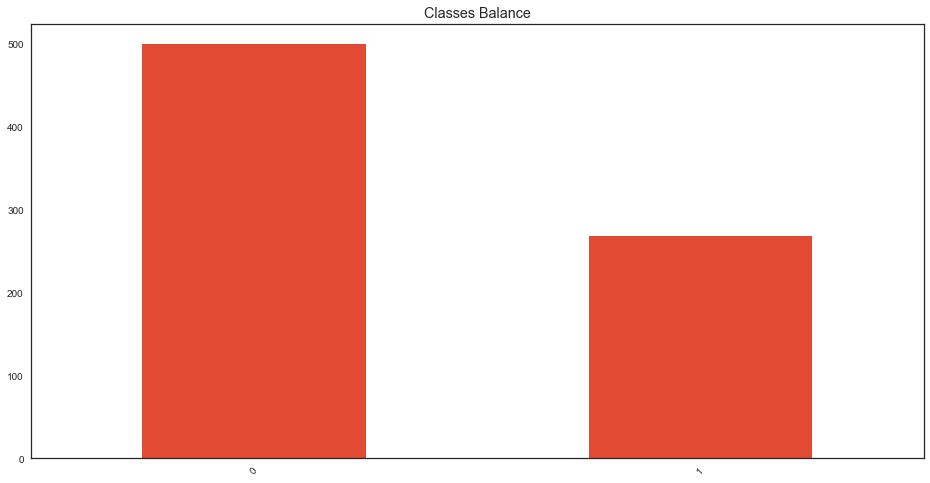

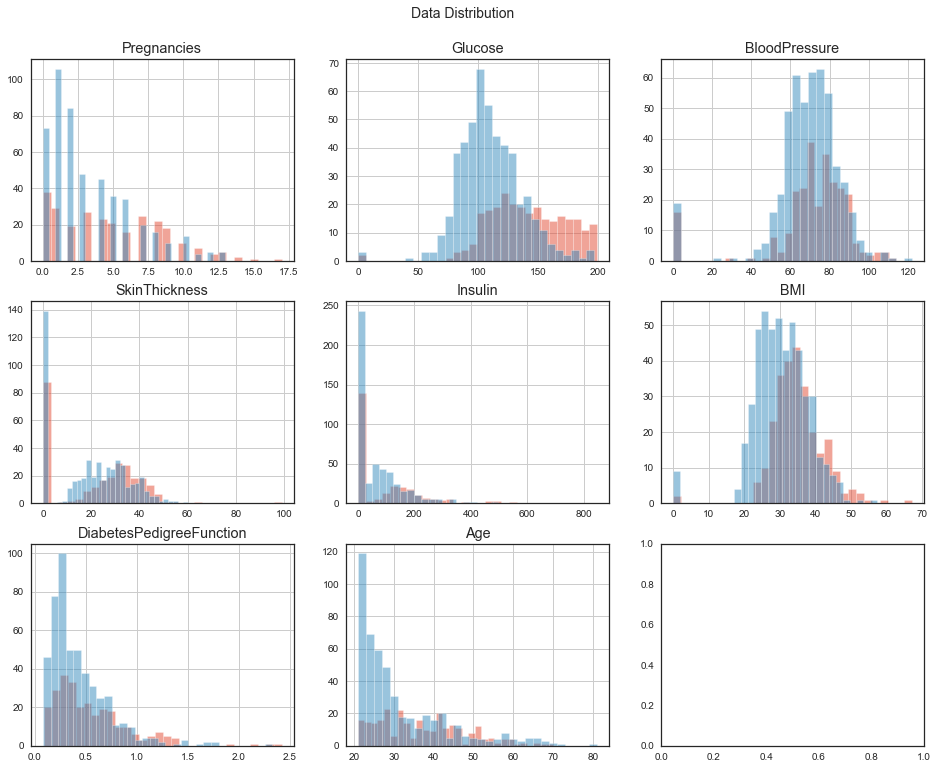

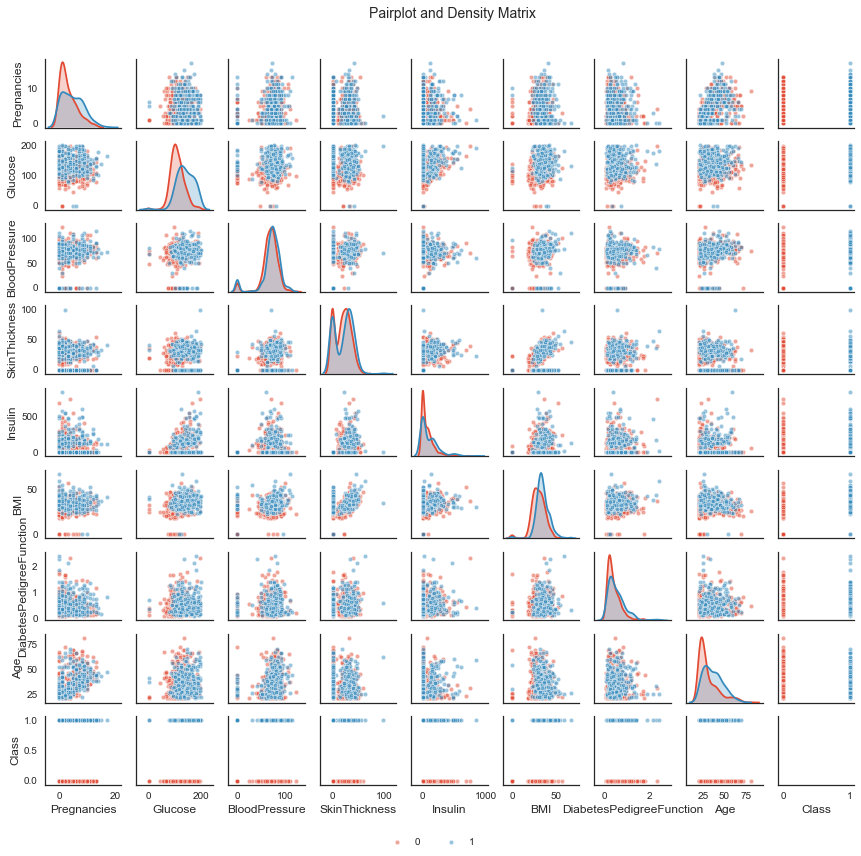

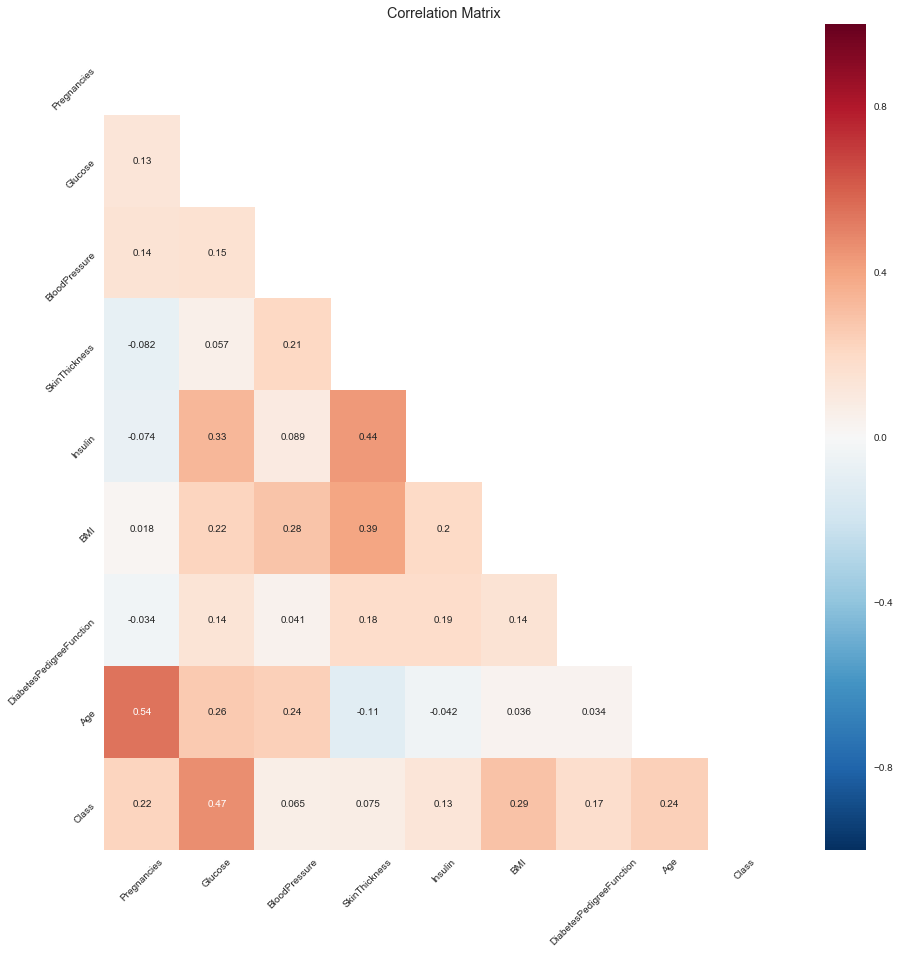

In [34]:
# please inform the output column here, a list of columns can also be ignored if necessary
# columns listed as ignored will be discarded while modeling
# flag graph to true to show some exploratory and correlation graphs on the dataset

y_col = 'Class'
ignore_cols = []
rm.explore(rm.data_raw, y_col, ignore_cols, graph=True) #updates X, y, M

# conclusões: 
# 1. há algum desbalanceamento entre as classes, requer atenção especial ao analisar precisão, recall e f1-score
# 2. a dimensão de domínio dos diferentes Xs é diversificada indo de unidade a milhar, requer transformação destes dados
# 3. há um grande número de registros com valores zerados, especialmente para Insulin e SkinThickness, vamos tratar isto
# 4. nenhuma variável independente apresenta correlação forte com a variável dependente -> requer modelagem avançada
# 5. nenhuma correlação não linear aparente, podemos seguir sem a adição de termos polinomiais ou cruzados por enquanto

***************************************************************************************************************************** 
*
* FEATURE EXTRACTION REPORT 
*
* X:  Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI | DiabetesPedigreeFunction | Age
* y:  Class
* M:  (768, 8) | (768, 1)
* 
*****************************************************************************************************************************



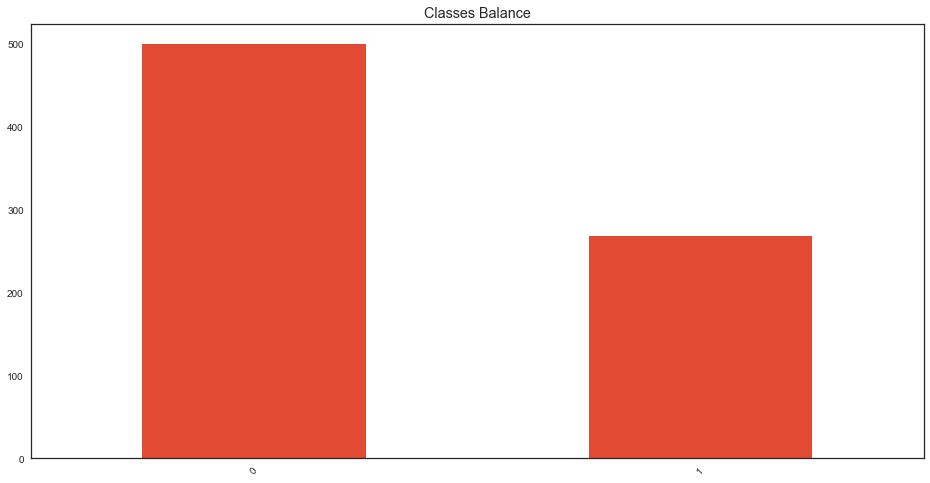

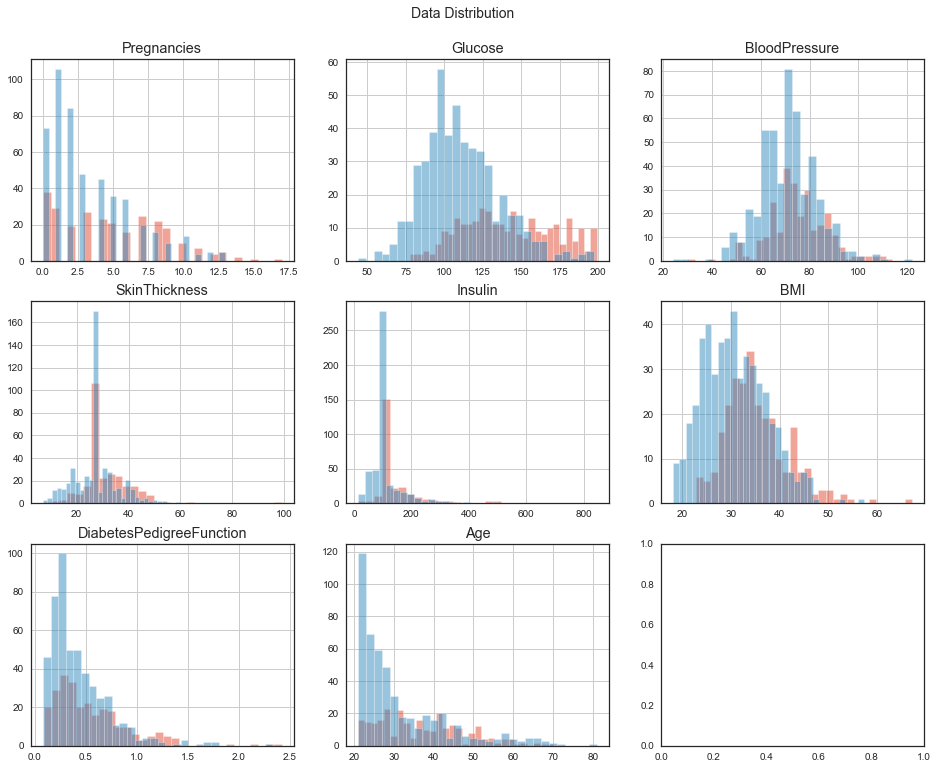

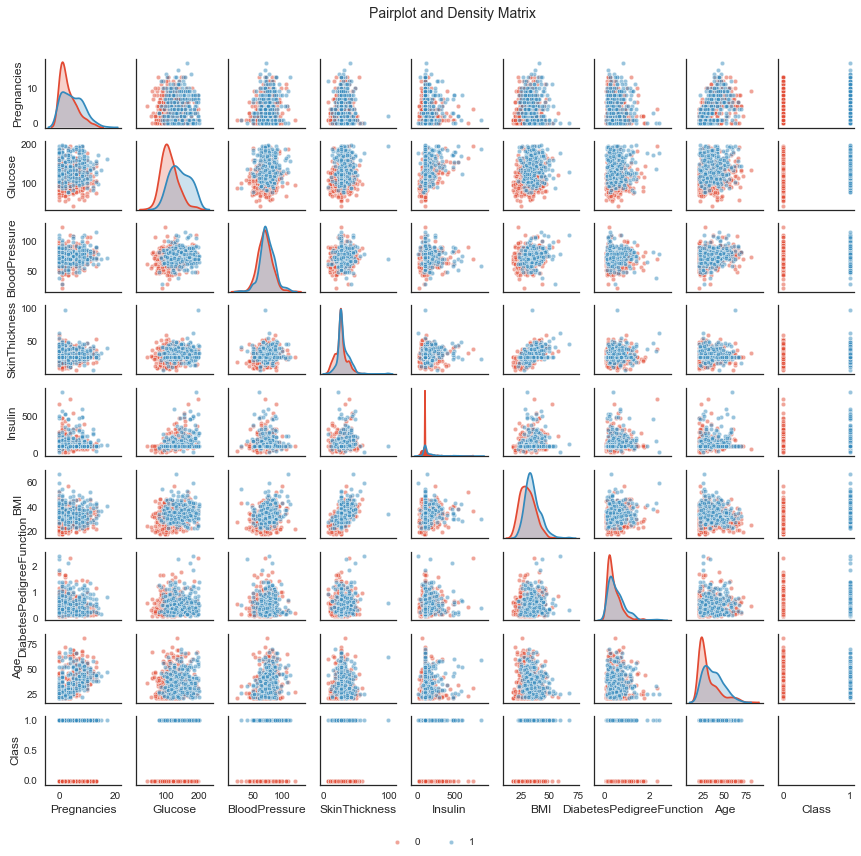

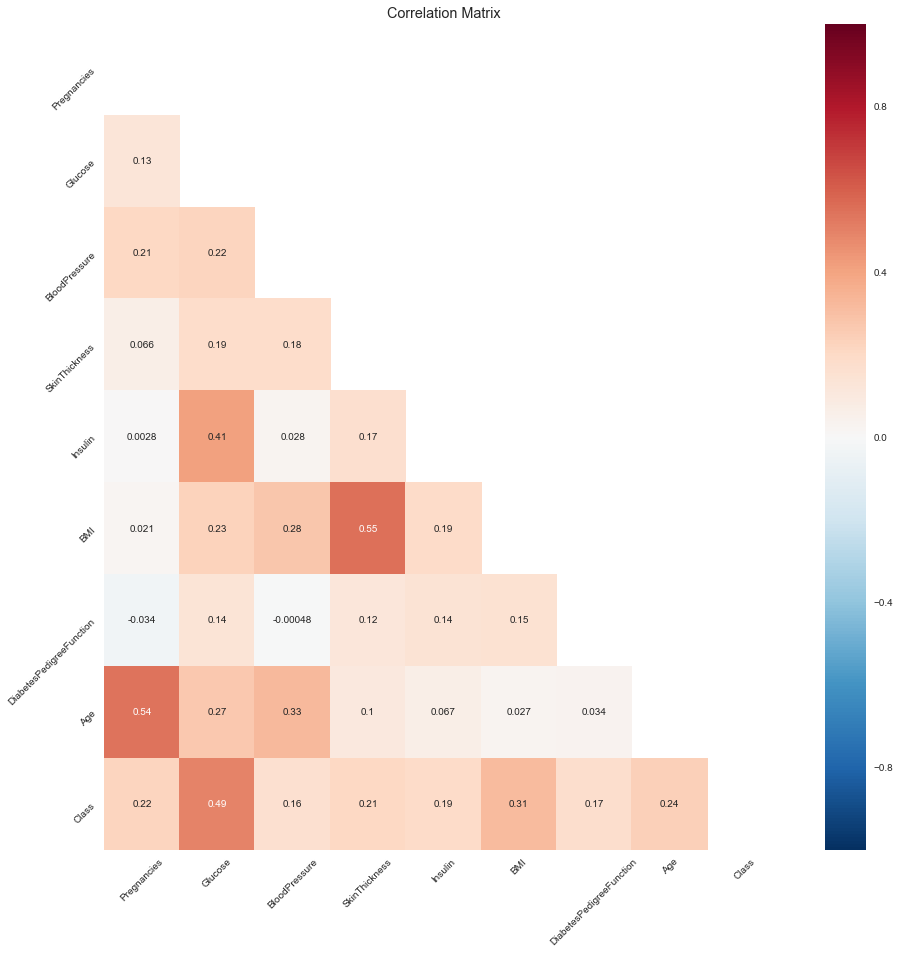

In [35]:
# do ponto de vista prático, nenhum dos valores de BloodPressure, SkinThickness, BMI ou Glucose poderiam ser nulos
# insulina até poderia ser nula para a classe 1 porém vemos a proporção menor para esta classe
# vamos substituir os valores zerados pela mediana para as respectivas classes

cols = ['BloodPressure', 'SkinThickness', 'BMI', 'Glucose', 'Insulin']
for col in cols:
    # calcular a mediana para a coluna e classe, excluindo os valores zerados
    mediana_0 = rm.data_raw[(rm.data_raw[col]!=0)&(rm.data_raw.Class==0)][col].median()
    mediana_1 = rm.data_raw[(rm.data_raw[col]!=0)&(rm.data_raw.Class==0)][col].median()
    # substituir as medianas nos campos nulos
    rm.data_raw.loc[(rm.data_raw[col]==0)&(rm.data_raw.Class==0), col] = mediana_0
    rm.data_raw.loc[(rm.data_raw[col]==0)&(rm.data_raw.Class==1), col] = mediana_1

rm.explore(rm.data_raw, y_col, ignore_cols, graph=True) #updates X, y, M

# conclusões:
# 1. voltar a reanalisar este tratamento caso a performance do modelo não fique satisfatória

In [36]:
# observamos um outlier em SkinThickness
# um estudo na Colômbia mostrou que 97% das mulheres aos 18 anos apresentam valores inferiores a 40mm
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5083983/

rm.data_raw.SkinThickness.max()

99.0

In [37]:
# conclusões:
# 1. o valor de 99mm está bastante distante disso, vamos considerá-lo como um outlier e remover da base

rm.data_raw.drop(rm.data_raw.loc[rm.data_raw.SkinThickness == 99].index, inplace=True)

In [38]:
# encode every column of type object or string to categorical numbers
#rm.encode()

# conclusões:
# 1. este dataset não requer a codificação de nenhuma coluna, todos os valores já são contínuos ou categóricos numéricos

In [39]:
# add higher level and interaction terms to the model
# be carefull when using higher level terms and graphs together, less powerfull hardware can bottleneck with higher complexity

#rm.addTerms(rm.X, rm.y, levels=1, interaction=False, root=False)
#rm.explore(rm.M, y_col, ignore_cols, graph=False) #updates X, y, M

# conclusões:
# 1. addTerms é desnecessária nesse caso, onde não queremos adicionar termos polinomiais, interações e termos raíz

In [40]:
# analyse if this is a regression or a classification problem and evaluate some models
# when y is float or has more then 10 different classes, the algorithm turns into a regression algorithm automatically
# else it will perform a classification modeling

rm.analyse(y_col)
print(rm.strategy)

# conclusões:
# 1. o algoritmo identificou automaticamente este como sendo um problema de classificação

classification


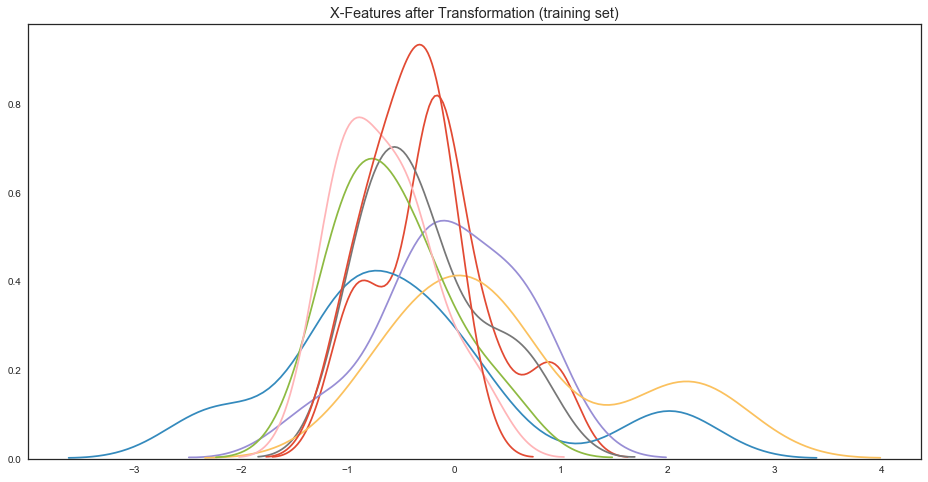



***************************************************************************************************************************** 
*
* CLASSIFICATION RESULTS - BEFORE PARAMETERS BOOSTING 
*
***************************************************************************************************************************** 


,Classifier,Score (avg),Score (std),Score (VC)
10,Random forest classifier,0.776275,0.059266,7.634623
11,Gradient boosting classifier,0.757897,0.048685,6.423739
5,SVM classifier with RBF kernel,0.755765,0.059623,7.889096
4,Logistic classifier,0.754088,0.060731,8.053503
6,SVM classifier with linear kernel,0.752411,0.046609,6.194590
2,K nearest neighbors classifier K10,0.752166,0.041638,5.535745
7,Gaussian naive bayes,0.744899,0.042479,5.702700
1,K nearest neighbors classifier K5,0.739308,0.028843,3.901352
3,Decision tree classifier,0.730259,0.056201,7.696065
8,Bernoulli naive bayes,0.711251,0.051958,7.305228


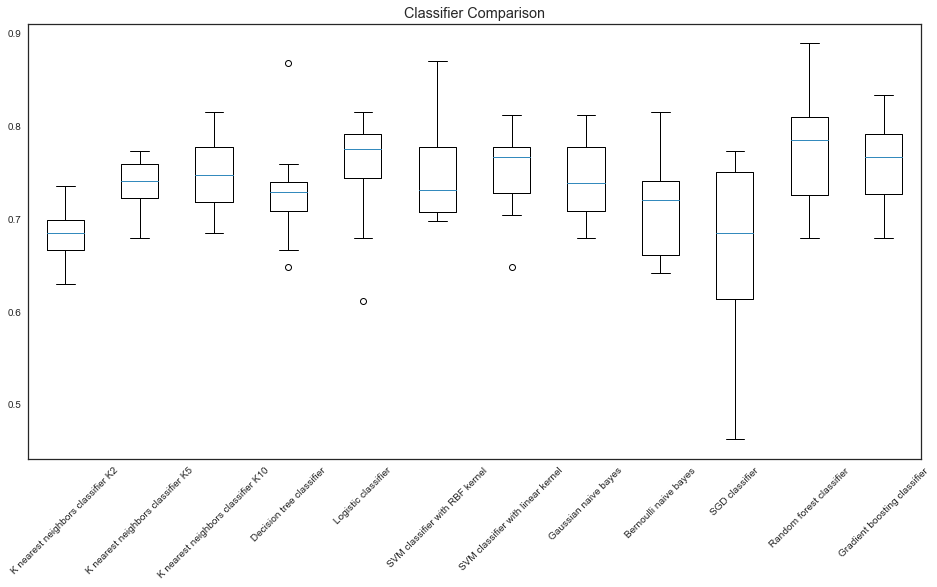

In [41]:
# define a few mode parameters and call the model evaluation procedure

alphas = 10 ** np.linspace(10, -2, 100) * 0.5
rm.evaluate(test_size=0.3, transformX='xstandard', transformY='ynone', folds=10, alphas=alphas, graph=True, metric='neg_mean_squared_error')

# conclusões:
# 1. o regressor logístico apresentou a melhor taxa de acertos no treino e também um CV baixo, mostrando boa repetitivadade



***************************************************************************************************************************** 
*
* MODEL PERFORMANCE 
*
* MODEL NAME:  SGD classifier
* TEST SAMPLE SIZE:  231
* ACCURACY:  66.7 %
* 
***************************************************************************************************************************** 



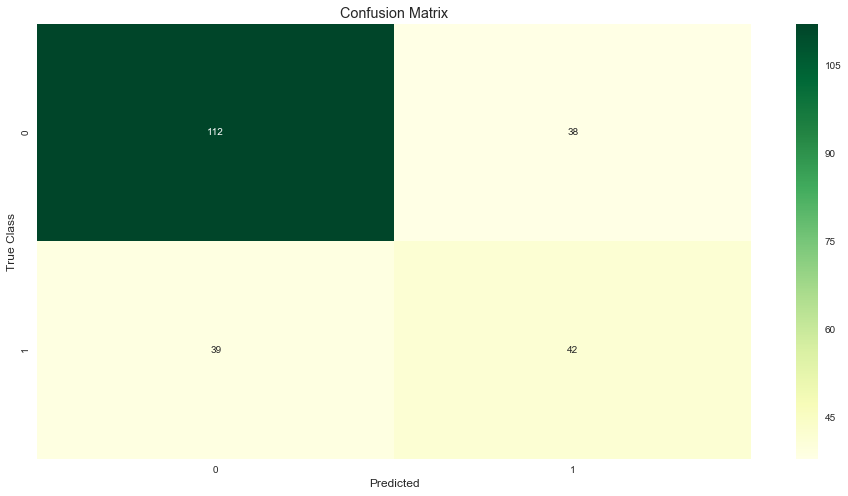

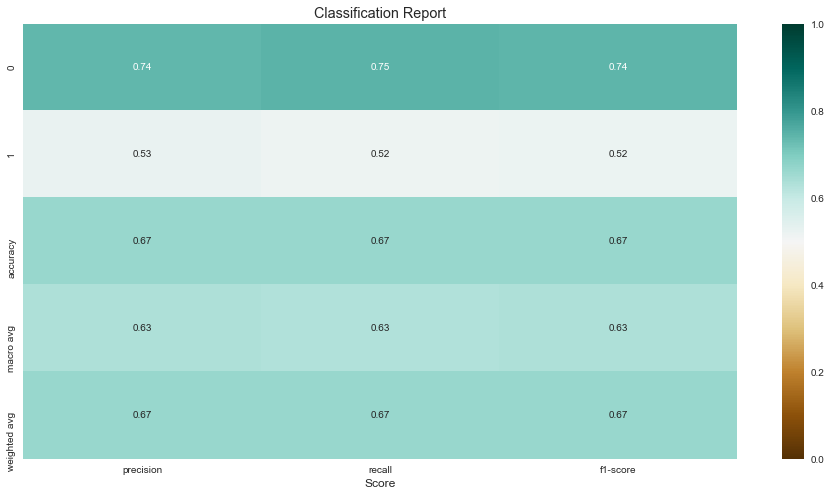

In [42]:
rm.test('SGD classifier', graph=True)

# conclusões:
# 1. o SGD não obteve bons resultados de recall e por consequência de f1 para a classe 1



***************************************************************************************************************************** 
*
* MODEL PERFORMANCE 
*
* MODEL NAME:  Logistic classifier
* TEST SAMPLE SIZE:  231
* ACCURACY:  78.4 %
* 
***************************************************************************************************************************** 



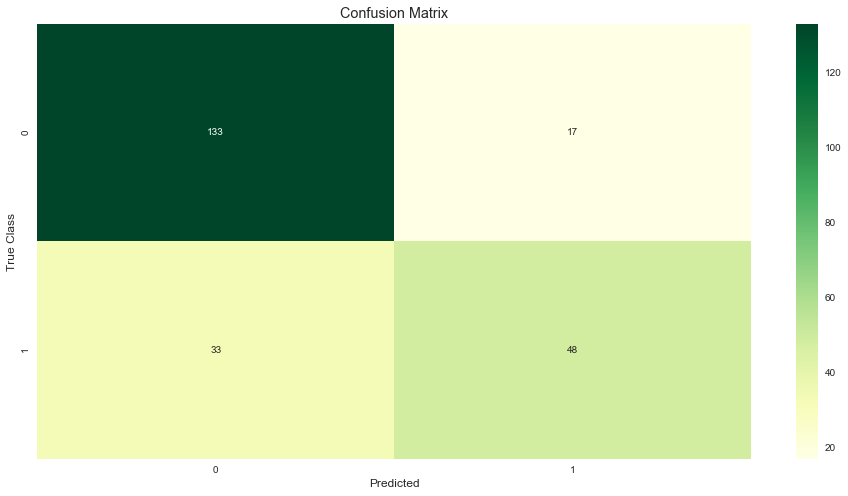

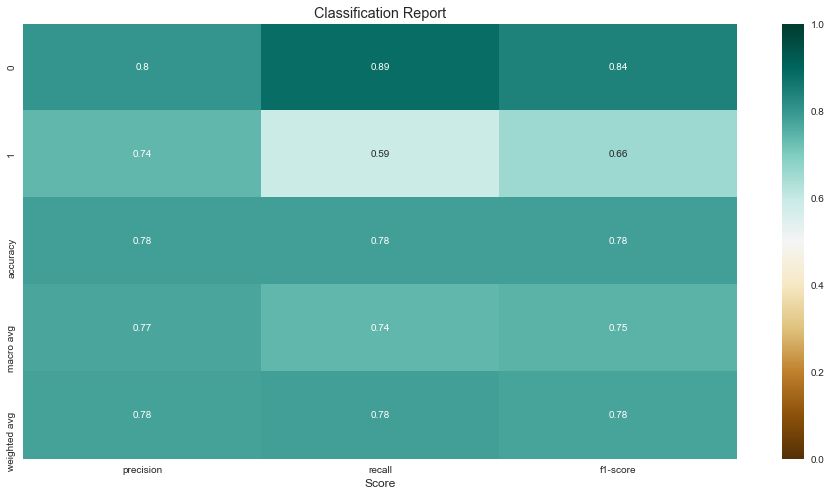

In [43]:
rm.test('Logistic classifier', graph=True)

# conclusões:
# 1. obtivemos resultado satisfatório para o regressor logístico também na base de teste, com recall baixo ainda para classe 1

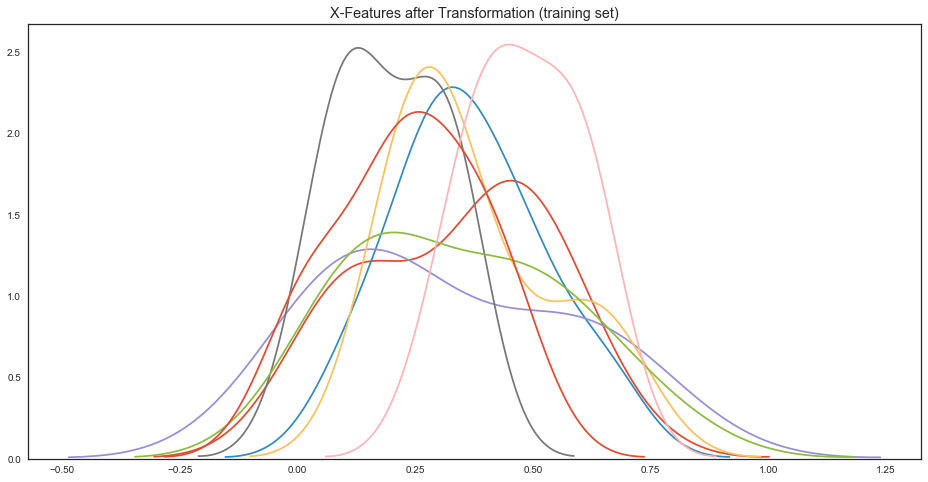



***************************************************************************************************************************** 
*
* CLASSIFICATION RESULTS - BEFORE PARAMETERS BOOSTING 
*
***************************************************************************************************************************** 


,Classifier,Score (avg),Score (std),Score (VC)
4,Logistic classifier,0.770790,0.047876,6.211229
6,SVM classifier with linear kernel,0.767400,0.045654,5.949161
10,Random forest classifier,0.763836,0.054602,7.148431
5,SVM classifier with RBF kernel,0.763662,0.048559,6.358730
2,K nearest neighbors classifier K10,0.752131,0.061028,8.113952
7,Gaussian naive bayes,0.743082,0.041027,5.521181
11,Gradient boosting classifier,0.741265,0.071471,9.641780
1,K nearest neighbors classifier K5,0.741160,0.049558,6.686611
0,K nearest neighbors classifier K2,0.709469,0.051960,7.323776
9,SGD classifier,0.700454,0.079359,11.329608


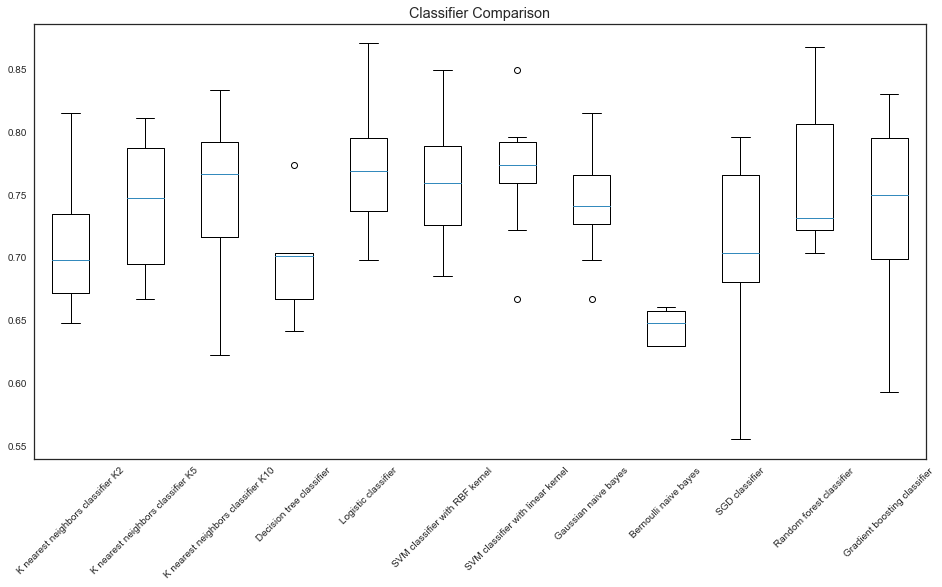

In [44]:
# vamos testar outra transforamção em X e avaliar novamente

rm.evaluate(test_size=0.3, transformX='xminmax', transformY='ynone', folds=10, alphas=alphas, graph=True, metric='neg_mean_squared_error')

# conclusões:
# 1. desempenhos semelhantes



***************************************************************************************************************************** 
*
* MODEL PERFORMANCE 
*
* MODEL NAME:  SGD classifier
* TEST SAMPLE SIZE:  231
* ACCURACY:  74.0 %
* 
***************************************************************************************************************************** 



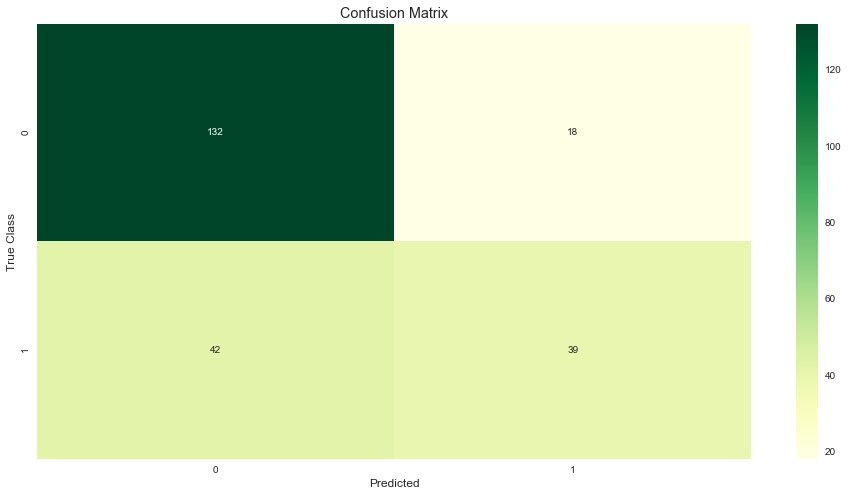

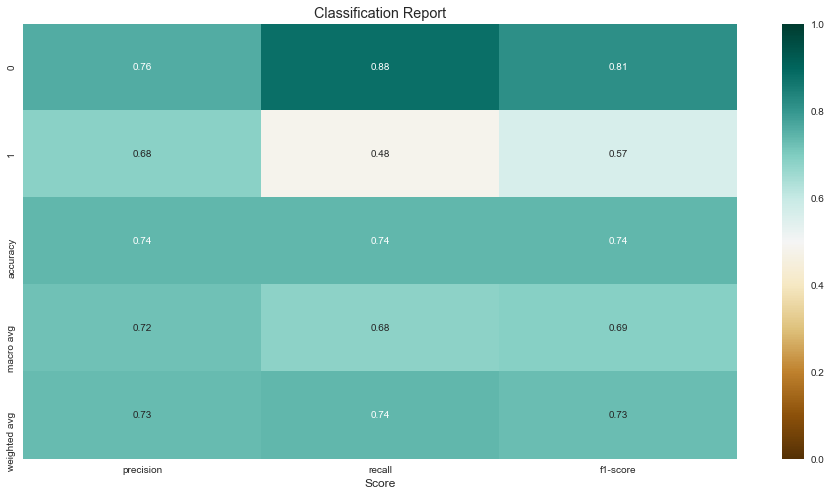

In [45]:
rm.test('SGD classifier', graph=True)

# conclusões:
# 1. desempenhos semelhantes



***************************************************************************************************************************** 
*
* MODEL PERFORMANCE 
*
* MODEL NAME:  Logistic classifier
* TEST SAMPLE SIZE:  231
* ACCURACY:  74.5 %
* 
***************************************************************************************************************************** 



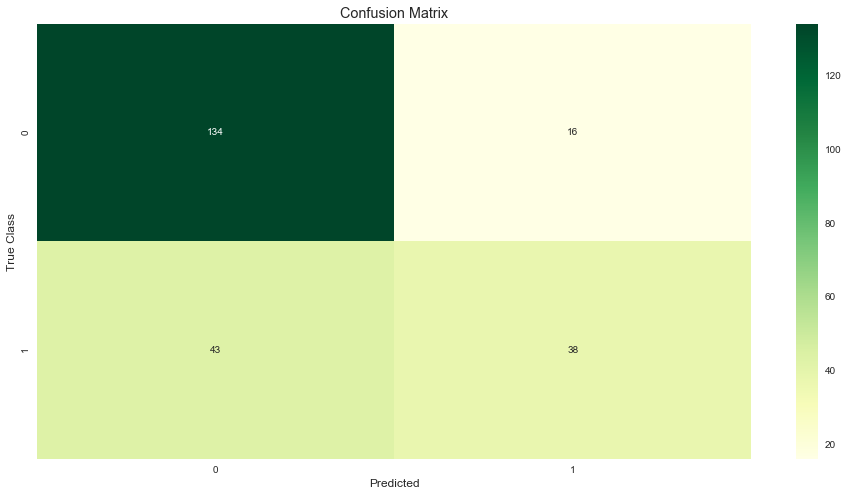

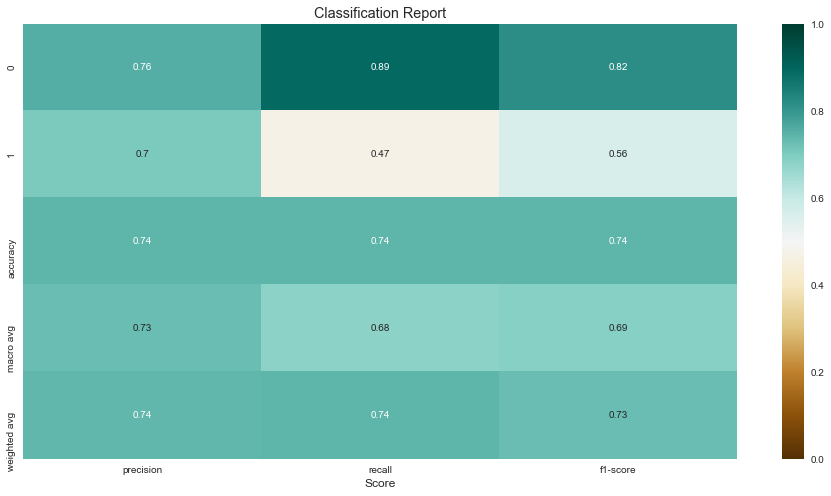

In [46]:
rm.test('Logistic classifier', graph=True)

# conclusões:
# 1. o desempenho do regressor logístico na base de testes piorou para o recall, demais índices semelhantes

## Resultados:
* Encontramos uma acurácia final na faixa de 75 a 80% para o Regressor Logístico e entre 65 e 75% para o SGD  
* Demais modelos com desempenhos intermediários, sempre entre 60 e 90%
* Os resultados de precisão se mostram melhores do que os de recall (modelos ainda apresentando muitos Falso Negativos)
  
**Observações:**
* Como a base de dados é pequena, observamos uma variância significativa entre diferentes runs do algoritmo (isso ocorre devido diferentes splits do dataset bem como suas inicializações)
* Numa situação real, esses algoritmos não estão legais pois o recall para a classe Positivo foi sempre mediano, no caso de diabetes seria melhor que recall fosse alto mesmo que precisão fosse baixa (um diagnóstico de falso negativo pode matar o paciente)